In [26]:
using LinearAlgebra
using Plots
using BenchmarkTools
using ProgressMeter

In [27]:
include("Operators.jl")

laplacian! (generic function with 1 method)

In [28]:
using FFTW

In [29]:
global const ESCAPE_AXIS= 2;

In [30]:
# Research about the appropriate grid size for inhomogeneous media

# Appropriate values
zgrid= 1:1:100; # m
ygrid= 1:1; # m
xgrid= 1:1:100; # m
dx, dy, dz= step.([xgrid, ygrid, zgrid])

nz, ny, nx= length.([zgrid, ygrid, xgrid]);

In [31]:
# Constants
μ= μ0= 4π* 1e-7; # H/m x 1e3
ϵ= ϵ0= 8.85e-12; # F/m x 1e-3
σ= 0.1 .*ones(Float32, nx, ny, nz); # Ωm # we can include anisotropy too!!
σ[:,:,10:20].= 1.;
# σ[1:50,:,10:20].= 0.05;
ρ= 1 ./σ;

In [32]:
# Change tgrid according to dx for inhomogenous media
dt= 5e-9; #dx.*minimum(ϵ.*σ.*μ) .* 0.1;
tgrid= 0:dt:5e-6; #e-14;
nt= length(tgrid);

In [33]:
"""
Update E for one time step
"""
dσ= zeros(Float32, nx,ny,nz);
d2E= zeros(Float32, nx,ny,nz);
dE= zeros(Float32, nx,ny,nz);

function update_E!(E, d2E, d2E_temp, dE, ρ, dρ, dJs, dMs, nt, Δx, Δy, Δz, Δt)
    
    dfn= [d_x!, d_y!, d_z!];
    d2fn= [d2_x!, d2_y!, d2_z!];
    Δs= [Δx, Δy, Δz];
    
    for i in 1:3 # components
        
        laplacian!(d2E, d2E_temp, E[:,:,:,nt-1,i], Δx, Δy, Δz);
        dfn[i](dρ, ρ, Δs[i]);
        # println(nt)
        # size.([E, d2E, dJs])
        E[:,:,:,nt,i].= E[:,:,:,nt-1,i].+ Δt.*ρ./μ.*(d2E.- 0/ϵ .* dρ.- μ.*dJs[:,:,:,nt-1,i]- dMs[:,:,:,nt-1,i]);

#         it= [:,:,:,nt, component];
#         itp= [:,:,:,nt+1, component];
#         itm= [:,:,:,nt-1, component];
#         # println("update_E", size(E), "\t", size(E[itm...]))
#         if component==1
#             d2_x!(d2E, E[itm...].*σ, Δx);
#             d_x!(dσ, σ, Δx);
#         elseif component==2
#             d2_y!(d2E, E[itm...].*σ, Δy);
#             d_y!(dσ, σ, Δy);
#         else
#             d2_z!(d2E, E[itm...].*σ, Δz);
#             d_z!(dσ, σ, Δz);
#         end
#         # println("update_E", mean(E), "\t", mean(E[:,:,:,nt,:]), "\t", mean(σ), "\t", mean(dσ), "\t", mean(d2E))
        
#         E[it...].= E[itm...].- μ0*Δt .*1 ./σ.*(1/μ0.*d2E- 1 ./(μ0*ϵ0).*dσ);
        
        
    end 
    
end

update_E! (generic function with 1 method)

In [34]:
function update_H!(H, E, dE3, dE_p, dE_m, dMs, nt, Δx, Δy, Δz, Δt)
    # @show size(dE3)
    curl!(dE3, dE_p, dE_m, view(E, :,:,:,nt-1,:), Δx, Δy, Δz)
    H[:,:,:,nt,:].= H[:,:,:,nt-1,:].-1/μ.*Δt.*(dE3).+ Δt.*dMs[:,:,:,nt-1,:];
end

update_H! (generic function with 1 method)

In [35]:
E= zeros(Float32, nx, ny, nz, nt, 3);
H= zeros(Float32, nx, ny, nz, nt, 3);

d2E= zeros(Float32, nx, ny, nz);
dE= zeros(Float32, nx, ny, nz);
dE3= zeros(Float32, nx, ny, nz, 3);
dE_p= zeros(Float32, nx, ny, nz);
dE_m= zeros(Float32, nx, ny, nz);
d2E_temp= zeros(Float32, nx, ny, nz);


dρ= zeros(nx,ny,nz);


# Intialize σ apropriately (Did it already)

In [36]:
Js= zeros(nx, ny, nz, nt, 3)
Js[(Int(round(nx/2))),1,(Int(round(nz/2))),:,3].= 1000 .*sin.(5 .*(1:nt)./nt *2π);
dJs= zeros(nx, ny, nz, nt, 3)
djs= zeros(1,nt);
diff!(djs, Js[(Int(round(nx/2))),:,(Int(round(nz/2))),:,3], 2, [:,1], [:,1], [:,1], dt)
# dJs[(Int(round(nx/2))),:,(Int(round(nz/2))),:,3].= djs;

In [37]:
Ms= zeros(nx, ny, nz, nt, 3)
dMs= zeros(nx, ny, nz, nt, 3)
dMs_p= zeros(nx, ny, nz)
dMs_m= zeros(nx, ny, nz)
# f= 8e3;
# (Int(round(nz/2)))
# Magnetic dipole
Ms[40:60,1,1,1,2]= -1:0.1:1;# .*sin.(2π*f.* tgrid);# (500 .*(1:nt)./nt *2π);
# for freq in 2e3:5e2:10e3
#     Ms[25:26,1,1,:,3].= Ms[25:26,1,1,:,3].+ 1 .*sin.(2π*freq.* reshape(tgrid, 1,nt));
# end
for it in 1:nt
    curl!(view(dMs,:,:,:,it,:), dMs_p, dMs_m, Ms[:,:,:,it,:], dx, dy, dz);
end

In [38]:
@showprogress for it in 2:nt
    update_E!(E, d2E, d2E_temp, dE, ρ, dρ, dJs, dMs, it, dx, dy, dz, dt);
    update_H!(H, E, dE3, dE_p, dE_m, dMs, it, dx, dy, dz, dt);
    # if it==5 break; end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


In [39]:
anim= @animate for it in 1:20:nt
    p1= heatmap(H[:,1,:,it,1]', yflip= true, title= "$it")#, clim= (-0.2,0.2))
    p2= heatmap(H[:,1,:,it,2]', yflip= true, title= "$it")#, clim= (-0.2,0.2))
    p3= heatmap(H[:,1,:,it,3]', yflip= true, title= "$it")# clim= (-0.2,0.2))
    plot(p1,p2,p3, layout= (1,3), size= (1000, 300))
end

Animation("/var/folders/x1/3hy4wtvs4b33gn48_tg_n29w0311lh/T/jl_mXpip7", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000042.png", "000043.png", "000044.png", "000045.png", "000046.png", "000047.png", "000048.png", "000049.png", "000050.png", "000051.png"])

┌ Info: Saved animation to /Users/asingh933/Desktop/wassup_danger/wave_simulation/Finite difference/magnetic_field.gif
└ @ Plots /Users/asingh933/.julia/packages/Plots/zzg7i/src/animation.jl:149


Plots.AnimatedGif("/Users/asingh933/Desktop/wassup_danger/wave_simulation/Finite difference/magnetic_field.gif")
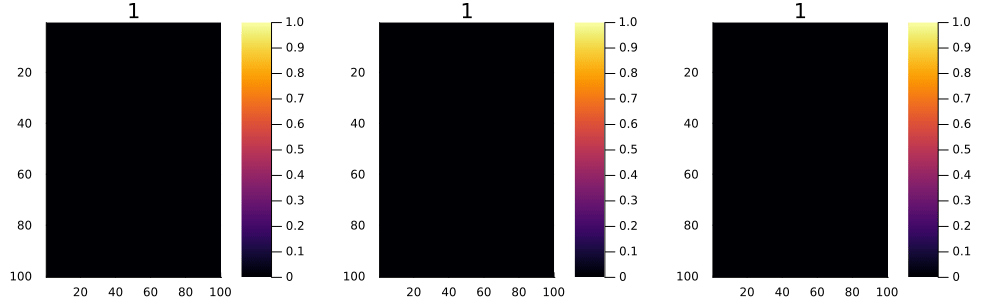

In [40]:
gif(anim, "magnetic_field.gif")

In [41]:
anim= @animate for it in 1:20:nt
    p1= heatmap(E[:,1,:,it,1]', yflip= true, title= "$it")#, clim= (-1,1))
    p2= heatmap(E[:,1,:,it,2]', yflip= true, title= "$it")#, clim= (-1,1))
    p3= heatmap(E[:,1,:,it,3]', yflip= true, title= "$it")#, clim= (-1,1))
    plot(p1,p2,p3, layout= (1,3), 
        size= (1000, 300))
end

Animation("/var/folders/x1/3hy4wtvs4b33gn48_tg_n29w0311lh/T/jl_KLCNma", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000042.png", "000043.png", "000044.png", "000045.png", "000046.png", "000047.png", "000048.png", "000049.png", "000050.png", "000051.png"])

┌ Info: Saved animation to /Users/asingh933/Desktop/wassup_danger/wave_simulation/Finite difference/electric_field.gif
└ @ Plots /Users/asingh933/.julia/packages/Plots/zzg7i/src/animation.jl:149


Plots.AnimatedGif("/Users/asingh933/Desktop/wassup_danger/wave_simulation/Finite difference/electric_field.gif")
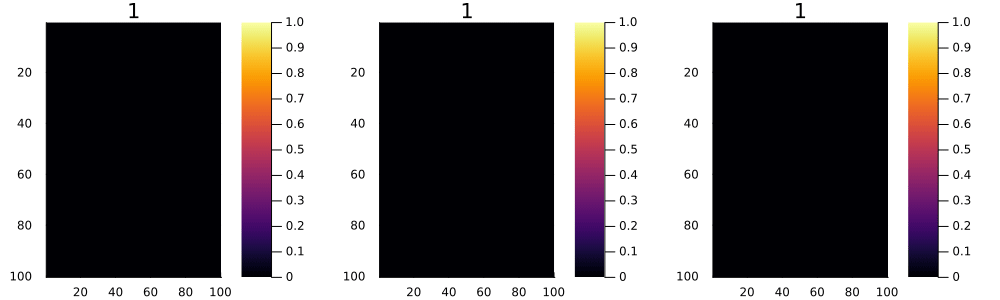

In [42]:
gif(anim, "electric_field.gif")

In [43]:
anim= @animate for it in 1:20:nt
    p1= heatmap(σ[:,1,:]'.*E[:,1,:,it,1]', yflip= true, title= "$it", c=:viridis)#, clim= (-1,1))
    p2= heatmap(σ[:,1,:]'.*E[:,1,:,it,2]', yflip= true, title= "$it")#, clim= (-1,1))
    p3= heatmap(σ[:,1,:]'.*E[:,1,:,it,3]', yflip= true, title= "$it")#, clim= (-1,1))
    plot(p1,p2,p3, layout= (1,3), size= (1000, 300))
end

Animation("/var/folders/x1/3hy4wtvs4b33gn48_tg_n29w0311lh/T/jl_hAlmJL", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000042.png", "000043.png", "000044.png", "000045.png", "000046.png", "000047.png", "000048.png", "000049.png", "000050.png", "000051.png"])

┌ Info: Saved animation to /Users/asingh933/Desktop/wassup_danger/wave_simulation/Finite difference/current density.gif
└ @ Plots /Users/asingh933/.julia/packages/Plots/zzg7i/src/animation.jl:149


Plots.AnimatedGif("/Users/asingh933/Desktop/wassup_danger/wave_simulation/Finite difference/current density.gif")
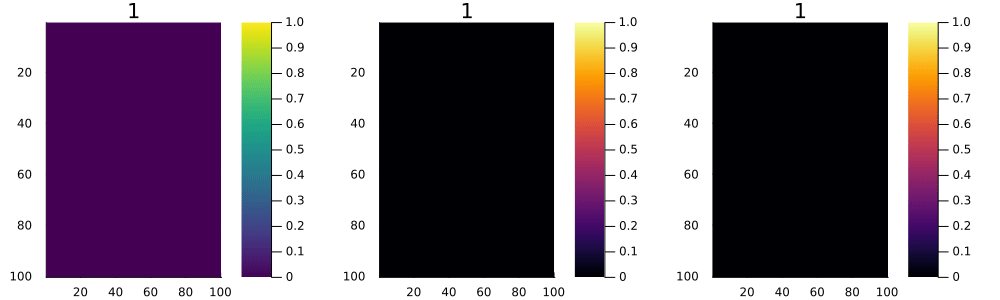

In [44]:
gif(anim, "current density.gif")